In [1]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import warnings
warnings.filterwarnings("ignore")
from data_generator import *
from models import matting_net

def convert_checkpoint_into_tflite(h5_path=None,
                                   output_path=None,
                                   android=True):
    if android:
        model = matting_net((256,256,4),batchnorm=True, android=True)
        
    else:
        model = matting_net((256,256,3), android=False)
    # model 명 과 상세사항 정리해두기 
    model.load_weights(h5_path, by_name=False)

    input_names = [node.op.name for node in model.inputs]
    output_names = [node.op.name for node in model.outputs]
    print(input_names)
    print(output_names)

    sess = K.get_session()
    converter = tf.lite.TFLiteConverter.from_session(sess, model.inputs, model.outputs)

    tflite_model = converter.convert()
    open(output_path, "wb").write(tflite_model)
    print("tflite successfully built")
    
    return model

Using TensorFlow backend.
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 256, 256, 8)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [2]:
tf.__version__

'1.14.0'

In [3]:
model = convert_checkpoint_into_tflite(h5_path="./trained_models/20191210/130.h5",
                                       output_path="./tflite/20191210_130.tflite", 
                                       android=True)

## Model output test

In [4]:
model.save_weights("sample.h5")

In [5]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:] / 255.
img = img.astype(np.float32)
# img = img[np.newaxis,:,:,:] / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

pred = model.predict(img)

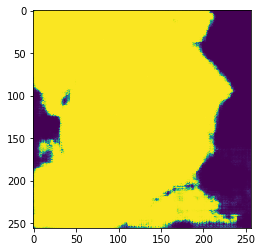

In [6]:
plt.imshow((pred * 255).astype(np.uint).squeeze(0).squeeze(-1))

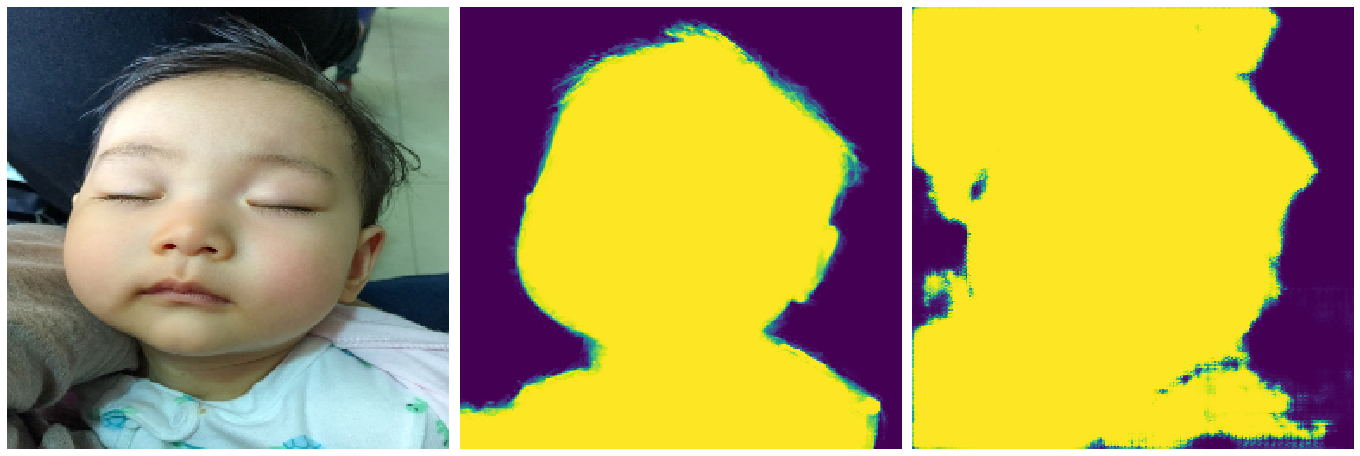

In [7]:
plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(132)
plt.imshow(mask)
plt.axis("off")

plt.subplot(133)
plt.imshow(pred.squeeze(0).squeeze(-1))
plt.axis("off")

plt.tight_layout()
plt.show()

(-0.5, 255.5, 255.5, -0.5)

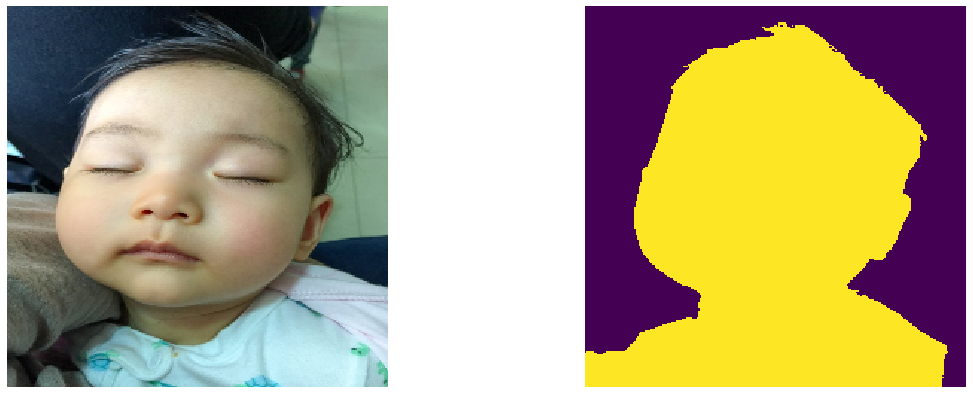

In [8]:
plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)[1])
plt.axis("off")

In [9]:
mask_ = tf.constant(cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)[1]/ 255.)
# pred_ = tf.constant(cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)[1] / 255.)
pred_ = tf.constant(pred.squeeze(0).squeeze(-1))

In [10]:
mask_ = tf.reshape(mask_, (1, 256, 256, 1))
pred_ = tf.reshape(pred_, (1, 256, 256, 1))

In [11]:
def iou_coef(y_true, y_pred, smooth=1):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    threshold = tf.constant(0.5, dtype=tf.float32)
    
    y_true = tf.cast(y_true > threshold, dtype=tf.float32)
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float32)
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [12]:
def dice_loss(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

    return 1 - numerator / denominator


In [13]:
def focal_loss(alpha=0.25, gamma=2):
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
        return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        logits = tf.log(y_pred / (1 - y_pred))

        loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

        # or reduce_sum and/or axis=-1
        return tf.reduce_mean(loss)

    return loss

In [14]:
def ce_dl_combined_loss(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return tf.reduce_mean(keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred))


In [15]:
iou = iou_coef(mask_, pred_)
dice = dice_loss(mask_, pred_)
focal = focal_loss()(mask_, pred_)
com = ce_dl_combined_loss(mask_, pred_)

In [16]:
with tf.Session() as sess:
    dice_ = sess.run(dice)
    focal_ = sess.run(focal)
    iou_ = sess.run([iou,])
    com_ = sess.run(com)

In [17]:
pred

array([[[[3.7530050e-01],
         [5.7087660e-01],
         [8.2480866e-01],
         ...,
         [7.9834461e-04],
         [8.4519386e-04],
         [2.7586818e-03]],

        [[7.0199525e-01],
         [9.2648458e-01],
         [9.9181426e-01],
         ...,
         [3.2812357e-05],
         [6.1929226e-05],
         [6.3094497e-04]],

        [[8.2728982e-01],
         [9.7282320e-01],
         [9.9631375e-01],
         ...,
         [2.5629997e-06],
         [7.1823597e-06],
         [1.7815828e-04]],

        ...,

        [[8.4731185e-01],
         [9.7818583e-01],
         [9.9492872e-01],
         ...,
         [2.6139617e-04],
         [2.5105476e-04],
         [1.4891624e-03]],

        [[5.2443808e-01],
         [8.5419619e-01],
         [9.6995115e-01],
         ...,
         [1.0918677e-03],
         [2.1109879e-03],
         [3.7232935e-03]],

        [[2.6647326e-01],
         [4.1582835e-01],
         [7.7978981e-01],
         ...,
         [2.3073554e-03],
        


### This is the Proper value of the loses and metrics 

In [18]:
dice_, focal_, iou_, com_

(array([0.16485769], dtype=float32), 1.3315816, [0.7177008], 2.0288498)

### Model Output test 2

In [19]:
from sklearn.metrics import confusion_matrix  

def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [20]:
mask_ = cv2.threshold(mask, 255/2, 255, cv2.THRESH_BINARY)
pred_ = cv2.threshold(pred.squeeze(0).squeeze(-1), 0.5, 1, cv2.THRESH_BINARY)
compute_iou(mask_[1], pred_[1])

0.22607198982264462

In [21]:
import numpy as np
from sklearn.metrics import log_loss

def cross_entropy(y_true, y_pred):
#     y_true = y_true.flatten()
#     y_pred = y_pred.flatten()
    
    N = y_pred.shape[0]# * y_pred.shape[1]
    
    ce = -np.sum(y_true*np.log(y_pred + 1e-5)) / N
    
    return ce


ce = cross_entropy(mask, pred.squeeze(0).squeeze(-1))

ce

5548.82421875

In [22]:
train_params = {
            'dim': (256,256),
            'batch_size': 32,
            'n_channels': 3,
            'shuffle': True,
            'augment': True,
        }

In [23]:
img_paths = np.load("./dataset/img_paths.npy")

train_img_paths = np.random.choice(img_paths, int(img_paths.shape[0] * 0.8), replace=False)

test_img_paths = np.setdiff1d(img_paths, train_img_paths)

In [24]:
train_gen = DataGeneratorMatting(train_img_paths)

In [25]:
train_gen[0][0].shape

(32, 256, 256, 3)

In [26]:
for t in train_gen:
    try : 
        preds = model.predict(np.concatenate((t[0], np.ones((32, 256, 256, 1))), axis=-1))
#         ious = np.reduce_mean()
        ious = iou_coef(t[1], preds, smooth=1)
        with tf.Session() as sess:
            print(sess.run(ious))
            
        print(ious)
    except : 
        print("DONE")
# preds = model.predict(np.concatenate((train_gen[0][0], np.ones((32, 256, 256, 1))), axis=-1))

0.9041806
Tensor("Mean_4:0", shape=(), dtype=float32)
0.8659679
Tensor("Mean_5:0", shape=(), dtype=float32)
0.86612064
Tensor("Mean_6:0", shape=(), dtype=float32)
0.8978656
Tensor("Mean_7:0", shape=(), dtype=float32)
0.8850081
Tensor("Mean_8:0", shape=(), dtype=float32)
0.8835852
Tensor("Mean_9:0", shape=(), dtype=float32)
0.88823783
Tensor("Mean_10:0", shape=(), dtype=float32)
0.8542971
Tensor("Mean_11:0", shape=(), dtype=float32)
0.85235786
Tensor("Mean_12:0", shape=(), dtype=float32)
0.88731945
Tensor("Mean_13:0", shape=(), dtype=float32)
0.87435746
Tensor("Mean_14:0", shape=(), dtype=float32)
0.8730514
Tensor("Mean_15:0", shape=(), dtype=float32)
0.9009588
Tensor("Mean_16:0", shape=(), dtype=float32)
0.899739
Tensor("Mean_17:0", shape=(), dtype=float32)
0.87316823
Tensor("Mean_18:0", shape=(), dtype=float32)
0.8677354
Tensor("Mean_19:0", shape=(), dtype=float32)
0.90791273
Tensor("Mean_20:0", shape=(), dtype=float32)
0.85429645
Tensor("Mean_21:0", shape=(), dtype=float32)
0.8562012

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-3e8ca3ba5d86>", line 1, in <module>
    for t in train_gen:
  File "/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/keras/utils/data_utils.py", line 377, in __iter__
    for item in (self[i] for i in range(len(self))):
  File "/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/keras/utils/data_utils.py", line 377, in <genexpr>
    for item in (self[i] for i in range(len(self))):
  File "/Users/hyunkim/Desktop/Segmentation/Portrait-segmentation/data_generator.py", line 38, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/Users/hyunkim/Desktop/Segmentation/Portrait-segmentation/data_generator.py", line 91, in __data_generation
    mask_path=mask_ID)
  File "/User

KeyboardInterrupt: 

In [ ]:
train_gen[0][0].shape

In [ ]:
for pr in preds[10:20]:
    plt.imshow(pr.squeeze(-1))
    plt.show()

In [ ]:
res = list(map(lambda x: cross_entropy(x[0], x[1]), zip(train_gen[0][1], preds)))
print(np.mean(res))